Using device: cuda
Model loaded successfully
Extracting training features...
Extracting test features...
Training KNN classifier...

Test Accuracy: 0.9655
ROC AUC Score: 0.6797

Classification Report:
              precision    recall  f1-score   support

  0_Negative       0.97      1.00      0.98      2271
1_Amiloidose       0.36      0.06      0.11        77

    accuracy                           0.97      2348
   macro avg       0.66      0.53      0.55      2348
weighted avg       0.95      0.97      0.95      2348

Confusion Matrix:
[[2262    9]
 [  72    5]]


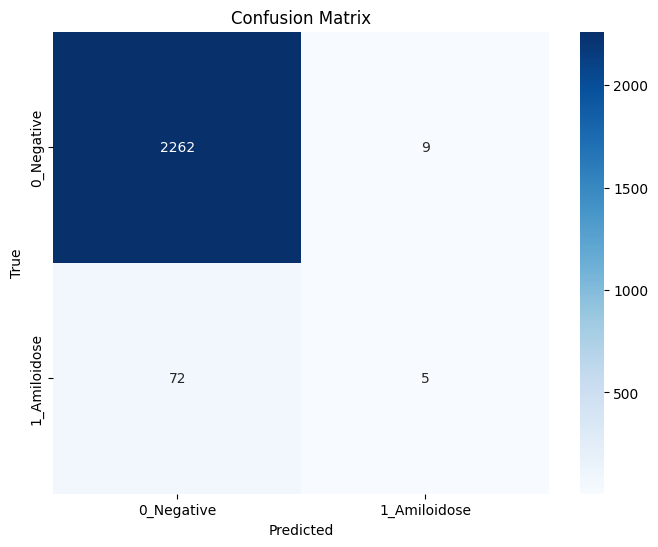

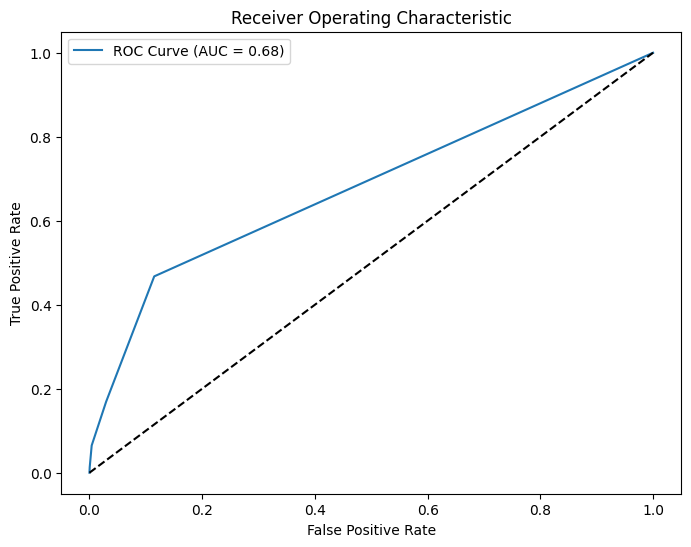

In [6]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_auc_score, roc_curve)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import pathlib

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load trained model
model_path = '/home/dora/uefs/LaCAD/Human-forgetting/logs/best_model.pth'
model = torch.load(model_path, map_location=device)
model.eval()
print("Model loaded successfully")

# Data configuration
base_path = pathlib.Path("/home/dora/uefs/LaCAD/Human-forgetting/fsl/0_Amiloidose/fold0")
test_path = "/home/dora/uefs/LaCAD/Human-forgetting/fsl/0_Amiloidose/fold0/val"  # Update if different

# Data transforms
transform_plain = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
])

# Create datasets
test_dataset = datasets.ImageFolder(test_path, transform=transform_plain)
train_dataset = datasets.ImageFolder(base_path / "train", transform=transform_plain)  # For class names

# Create data loaders
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

def extract_features(model, loader, device):
    """Extract features from model backbone"""
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            outputs = model.backbone(images).cpu().numpy()
            features.append(outputs)
            labels.append(targets.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features
print("Extracting training features...")
train_features, train_labels = extract_features(model, train_loader, device)
print("Extracting test features...")
test_features, test_labels = extract_features(model, test_loader, device)

# Train KNN classifier
print("Training KNN classifier...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, train_labels)

# Evaluate
test_preds = knn.predict(test_features)
test_probs = knn.predict_proba(test_features)[:, 1]

# Calculate metrics
accuracy = accuracy_score(test_labels, test_preds)
roc_auc = roc_auc_score(test_labels, test_probs)
conf_matrix = confusion_matrix(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds, target_names=train_dataset.classes)

# Print results
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}\n")
print("Classification Report:")
print(class_report)
print("Confusion Matrix:")
print(conf_matrix)

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()